## Scrape lyric sites for artist lyrics

In [86]:
import requests 
from bs4 import BeautifulSoup as soup
import re
import pandas as pd
import spacy
from itertools import compress
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
from sklearn.model_selection import learning_curve
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc

In [853]:
def linksRetrieve(artistName, listName, url, targetString, nameList):
    """creates link list file"""
    #retrieves html after permission granted
    artistName=requests.get(url)
    #convert request to coup object 
    pageHTML=soup(artistName.text, 'html.parser')
    listName=[]
    #retrieve every link from specific attribute and save into list 
    for link in pageHTML.find_all('a', attrs={'href':re.compile(targetString)}): 
        listName.append(link.get('href')) 
    listName=pd.DataFrame(listName)
    listName.to_csv(nameList+'.csv', header=['links'])

In [854]:
def lyricRetrieve(linkFile, artistName):
    """retrieves lyrics from every link and adds it to a list"""
    links=pd.read_csv(linkFile)
    songDF=[] ##save all song lyrics into list 
    #while len(songDF) < len(linkFile):
    for i in range(len(links)):
        url=links['links'].iloc[i] ##retrieve link from link list 
        songLink=requests.get(url) ##request permission to get info from site 
        songHTML=soup(songLink.text, 'html.parser') ##convert response to beautiful soup object
        lines='' ##for lyrics of each song 
        result=songHTML.find_all('p', {'class':"verse"})
        if not result:
            continue    
        for line in songHTML.find_all('p', {'class':"verse"}): ##retrieve each tag chunk
            line=str(line.text).replace('\'', '%temp%').replace('\n', ' ').replace('%temp%', ' ')+' ' ##convert to string and get rid of unwanted characters
            line=line.replace('(', '%temp%').replace(')', ' ').replace('%temp%', ' ')
            lines=lines+line ##concatenate all lines together into 1 string 
        songDF.append(lines) ##append each string song into a single list
    songDF=pd.DataFrame(songDF)
    songDF.to_csv(artistName+'.csv', header=['songs'])##save as csv file 

In [855]:
# create Lady Gaga csv files 
url='https://www.metrolyrics.com/lady-gaga-lyrics.html'
linksRetrieve('LadyGaga', 'gagaSongs', url, '-lyrics-lady-gaga', 'gagaLinks')
lyricRetrieve('gagaLinks.csv', 'gagaLyrics')

In [856]:
# create Frank Sinatra csv files 
url='https://www.metrolyrics.com/frank-sinatra-lyrics.html'
linksRetrieve('FrankSinatra', 'sinatraSongs', url, '-lyrics-frank', 'sinatraLinks')
lyricRetrieve('sinatraLinks.csv', 'sinatraLyrics')

## Cleaning up songs with Spacy

In [73]:
#instatiate model
mSpacy = spacy.load('en_core_web_md')

In [74]:
def cleanSong(lyricFile, model, artistName):
    """processes each songs' natural language and formats each string list of songs into a df"""
    #upload csv file and extract series songs 
    df=pd.read_csv(lyricFile)
    df=df['songs']
    songClean=[]
    for i in range(len(df)):
        #change all letters in each string to lower case 
        df1=df[i].lower()
        #deconstruct natural language of each string 
        tokenDF=model(df1)
        #grabs the specific tokens 
        word=[]; alpha=[]
        for token in tokenDF:
            word.append(token)
            alpha.append(token.is_alpha)
        #keeps only words identified as alpha into a list
        word=list(compress(word, alpha))
        #concatentates the words into a single string 
        word=' '.join(map(str, word))
        #appends each cleaned song as a string to a list 
        songClean.append(word)
    #converts the list in a df with the artist name as the index 
    songClean1=pd.DataFrame(songClean, columns=['songs'])
    songClean1['artistName']=artistName
    songClean1=songClean1.set_index('artistName')
    return songClean1

In [75]:
gaga=cleanSong('gagaLyrics.csv', mSpacy, 'Lady Gaga')

In [76]:
sinatra=cleanSong('sinatraLyrics.csv', mSpacy, 'Frank Sinatra')

## Transforming lyrics to word vectors and distinguishing word uniqueness

In [80]:
#create corpus by concatenating dfs together
corpus=pd.concat([gaga, sinatra], axis=0)
#creating word vectors 
tf=TfidfVectorizer()
tfVec=tf.fit_transform(corpus['songs'])
df=pd.DataFrame(tfVec.todense(), columns=cv.get_feature_names(), index=corpus.index)
#creating y variable for modeling 
df=df.reset_index()
df['artistName']=pd.factorize(df['artistName'])[0]
df.head()

,artistName,aah,about,above,acapulco,accept,aching,achtzehn,across,act,...,young,your,yours,yourself,youth,yule,zedd,zip,zombie,zone
0,0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.029751,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,0.0,0.03001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.013539,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.077150,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.004374,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.211009,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Model building and evaluation
- learning curve code based on this [post](https://chrisalbon.com/machine_learning/model_evaluation/plot_the_learning_curve/)
- good post on background info for [learning curves](https://www.dataquest.io/blog/learning-curves-machine-learning/)

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc

In [50]:
#split df to train/test
y=df4['artistName']
X=df4.drop('artistName', axis=1)

In [137]:
def modelEval(X, y, modName, params):
    """build model and evaluate it"""
    #split model
    xTrain, xTest, yTrain, yTest=train_test_split(X,y,test_size=0.2,random_state=42,stratify=y)
    #build model and calc its evaluating factors 
    m=LogisticRegression()
    m.fit(xTrain, yTrain)
    yPred=m.predict(xTest)
    print('model accuracy: ', accuracy_score(yTest, yPred))
    print('model precision: ', precision_score(yTest, yPred))
    print('model recall: ', recall_score(yTest, yPred))
    print('model f1: ', f1_score(yTest, yPred))
    #calculating variables for graphs 
    nsProbs=[0 for num in range(len(yTest))] ##random chance var for ROC curve
    nsFP, nsTP, _=roc_curve(yTest, nsProbs)
    nsProbs2=len(yTest[yTest==1])/len(yTest) ##random chance var for precision/recall graph
    mProbs=m.predict_proba(xTest)[:, 1] #calc prob 1 (one of the artist) for ROC & precision/recall
    print('AUC score: ', roc_auc_score(yTest, mProbs))
    mFP, mTP, _=roc_curve(yTest, mProbs) #components for ROC curve
    mPrecision, mRecall, _=precision_recall_curve(yTest, mProbs) #components for precision/recall curve
    cm=confusion_matrix(yTest, yPred) # for confusion matrix
    #create ROC and precision/recall graphs
    ##ROC graph
    fig, (g1,g2)=plt.subplots(1,2, figsize=(15,8))
    g1.plot(nsFP, nsTP, linestyle='--', label='No Skill')
    g1.plot(mFP, mTP, linestyle=':', label=modName)    
    g1.set_xlabel('False Positive Rate')
    g1.set_ylabel('True Positive Rate')
    g1.set_title('Reciever Operating Characteristic (ROC) Curve')
    g1.legend(loc='best')
    ##precision/recall graph
    g2.plot([0,1], [nsProbs2, nsProbs2], linestyle='--', label='No Skill')
    g2.plot(mRecall, mPrecision, marker='.', label=modName)
    g2.set_xlabel('Recall')
    g2.set_ylabel('Precision')
    g2.set_title('Precision-Recall (PR) Curve')
    g2.legend(loc='best')
    #create confusion matrix and learning curves
    ##confusion matrix
    fig, (g1,g2)=plt.subplots(1,2, figsize=(15,8))
    sns.heatmap(cm, annot=True, ax=g1)
    ##learning curve
    ##create various train/test scores for various training sets sizes
    trainSizes, trainScores, testScores=learning_curve(LogisticRegression(), X, y, cv=5, n_jobs=-1, 
                                                   train_sizes=np.linspace(0.1,1,50), shuffle=True, scoring='accuracy')
    ##calc mean and std of train/test scores
    trainMean=np.mean(trainScores, axis=1)
    trainSTD=np.std(trainScores, axis=1)
    testMean=np.mean(testScores, axis=1)
    testSTD=np.std(testScores, axis=1)
    ##create plot
    ###plot lines 
    g2.plot(trainSizes, trainMean, 'o-', color='b',label="Training score")
    g2.plot(trainSizes, testMean, 'o-', color='r',label="Cross-validation Score")
    ###plot bands 
    g2.fill_between(trainSizes, trainMean-trainSTD, trainMean+trainSTD, alpha=0.1, color='b')
    g2.fill_between(trainSizes, testMean-testSTD, testMean+testSTD, alpha=0.1, color='r')
    ###create plot
    g2.set_title("Learning Curves")
    g2.set_xlabel("Training set size")
    g2.set_ylabel("Accuracy score")
    g2.legend(loc="best")

model accuracy:  0.9354838709677419
model precision:  0.9333333333333333
model recall:  0.9333333333333333
model f1:  0.9333333333333333
AUC score:  0.9624999999999999


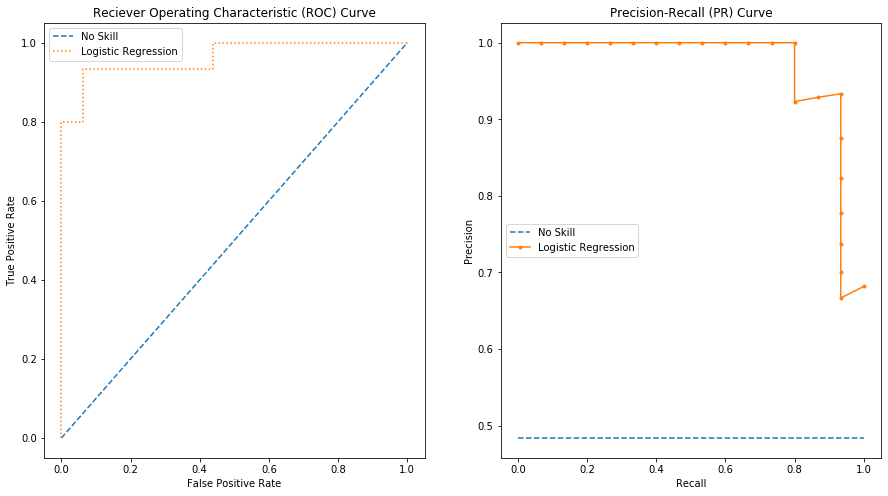

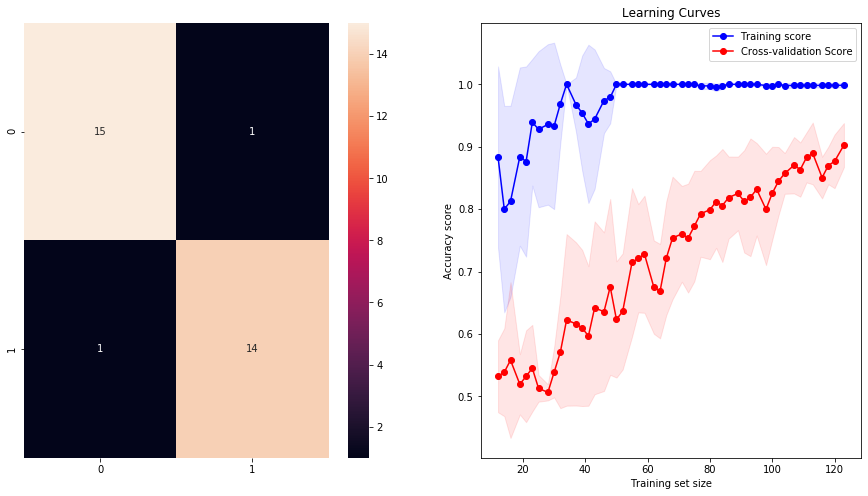

In [138]:
modelEval(X,y,'Logistic Regression', params={'C':1})

## Checking regularization model improvements: comparing learning curves

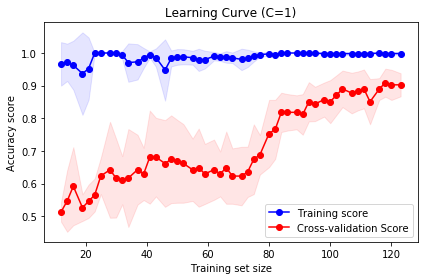

In [136]:
##Example of overfitting 
#attempt at learning curves 
##create various train/test scores for various training sets sizes
trainSizes, trainScores, testScores=learning_curve(LogisticRegression(), X, y, cv=5, n_jobs=-1, 
                                                   train_sizes=np.linspace(0.1,1,50), shuffle=True, scoring='accuracy')
##calc mean and std of train/test scores
trainMean=np.mean(trainScores, axis=1)
trainSTD=np.std(trainScores, axis=1)
testMean=np.mean(testScores, axis=1)
testSTD=np.std(testScores, axis=1)

##create plot
###plot lines 
plt.plot(trainSizes, trainMean, 'o-', color='b',label="Training score")
plt.plot(trainSizes, testMean, 'o-', color='r',label="Cross-validation Score")
###plot bands 
plt.fill_between(trainSizes, trainMean-trainSTD, trainMean+trainSTD, alpha=0.1, color='b')
plt.fill_between(trainSizes, testMean-testSTD, testMean+testSTD, alpha=0.1, color='r')
###create plot
plt.title("Learning Curve (C=1)")
plt.xlabel("Training set size")
plt.ylabel("Accuracy score")
plt.legend(loc="best")
plt.tight_layout()
plt.show()

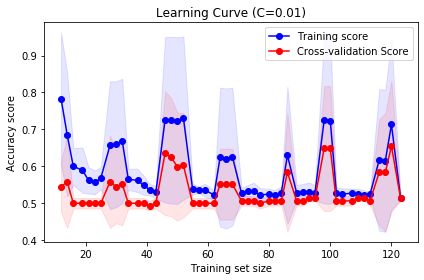

In [68]:
##Example of underfitting 
#attempt at learning curves 
##create various train/test scores for various training sets sizes
trainSizes, trainScores, testScores=learning_curve(LogisticRegression(C=0.01), X, y, cv=5, n_jobs=-1, 
                                                   train_sizes=np.linspace(0.1,1,50), shuffle=True, scoring='accuracy')
##calc mean and std of train/test scores
trainMean=np.mean(trainScores, axis=1)
trainSTD=np.std(trainScores, axis=1)
testMean=np.mean(testScores, axis=1)
testSTD=np.std(testScores, axis=1)

##create plot
###plot lines 
plt.plot(trainSizes, trainMean, 'o-', color='b',label="Training score")
plt.plot(trainSizes, testMean, 'o-', color='r',label="Cross-validation Score")
###plot bands 
plt.fill_between(trainSizes, trainMean-trainSTD, trainMean+trainSTD, alpha=0.1, color='b')
plt.fill_between(trainSizes, testMean-testSTD, testMean+testSTD, alpha=0.1, color='r')
###create plot
plt.title("Learning Curve (C=0.01)")
plt.xlabel("Training set size")
plt.ylabel("Accuracy score")
plt.legend(loc="best")
plt.tight_layout()
plt.show()

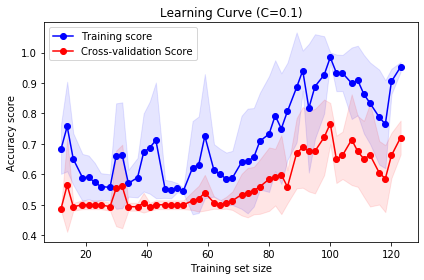

In [69]:
##Getting better
#attempt at learning curves 
##create various train/test scores for various training sets sizes
trainSizes, trainScores, testScores=learning_curve(LogisticRegression(C=0.1), X, y, cv=5, n_jobs=-1, 
                                                   train_sizes=np.linspace(0.1,1,50), shuffle=True, scoring='accuracy')
##calc mean and std of train/test scores
trainMean=np.mean(trainScores, axis=1)
trainSTD=np.std(trainScores, axis=1)
testMean=np.mean(testScores, axis=1)
testSTD=np.std(testScores, axis=1)

##create plot
###plot lines 
plt.plot(trainSizes, trainMean, 'o-', color='b',label="Training score")
plt.plot(trainSizes, testMean, 'o-', color='r',label="Cross-validation Score")
###plot bands 
plt.fill_between(trainSizes, trainMean-trainSTD, trainMean+trainSTD, alpha=0.1, color='b')
plt.fill_between(trainSizes, testMean-testSTD, testMean+testSTD, alpha=0.1, color='r')
###create plot
plt.title("Learning Curve (C=0.1)")
plt.xlabel("Training set size")
plt.ylabel("Accuracy score")
plt.legend(loc="best")
plt.tight_layout()
plt.show()

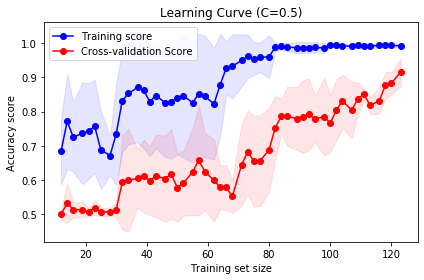

In [70]:
##Getting better
#attempt at learning curves 
##create various train/test scores for various training sets sizes
trainSizes, trainScores, testScores=learning_curve(LogisticRegression(C=0.5), X, y, cv=5, n_jobs=-1, 
                                                   train_sizes=np.linspace(0.1,1,50), shuffle=True, scoring='accuracy')
##calc mean and std of train/test scores
trainMean=np.mean(trainScores, axis=1)
trainSTD=np.std(trainScores, axis=1)
testMean=np.mean(testScores, axis=1)
testSTD=np.std(testScores, axis=1)

##create plot
###plot lines 
plt.plot(trainSizes, trainMean, 'o-', color='b',label="Training score")
plt.plot(trainSizes, testMean, 'o-', color='r',label="Cross-validation Score")
###plot bands 
plt.fill_between(trainSizes, trainMean-trainSTD, trainMean+trainSTD, alpha=0.1, color='b')
plt.fill_between(trainSizes, testMean-testSTD, testMean+testSTD, alpha=0.1, color='r')
###create plot
plt.title("Learning Curve (C=0.5)")
plt.xlabel("Training set size")
plt.ylabel("Accuracy score")
plt.legend(loc="best")
plt.tight_layout()
plt.show()

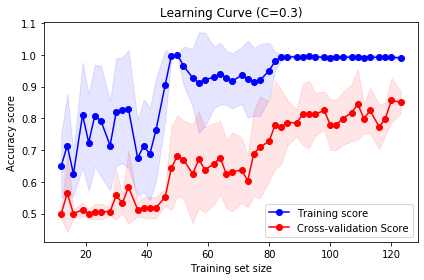

In [71]:
##Getting better
#attempt at learning curves 
##create various train/test scores for various training sets sizes
trainSizes, trainScores, testScores=learning_curve(LogisticRegression(C=0.3), X, y, cv=5, n_jobs=-1, 
                                                   train_sizes=np.linspace(0.1,1,50), shuffle=True, scoring='accuracy')
##calc mean and std of train/test scores
trainMean=np.mean(trainScores, axis=1)
trainSTD=np.std(trainScores, axis=1)
testMean=np.mean(testScores, axis=1)
testSTD=np.std(testScores, axis=1)

##create plot
###plot lines 
plt.plot(trainSizes, trainMean, 'o-', color='b',label="Training score")
plt.plot(trainSizes, testMean, 'o-', color='r',label="Cross-validation Score")
###plot bands 
plt.fill_between(trainSizes, trainMean-trainSTD, trainMean+trainSTD, alpha=0.1, color='b')
plt.fill_between(trainSizes, testMean-testSTD, testMean+testSTD, alpha=0.1, color='r')
###create plot
plt.title("Learning Curve (C=0.3)")
plt.xlabel("Training set size")
plt.ylabel("Accuracy score")
plt.legend(loc="best")
plt.tight_layout()
plt.show()